## Theoretic Bounds

Set up the functions as described in the paper

In [25]:
def FR(r,l):
    if l == 0:
        return 1
    return 2*r*(2*r-1)**(l-1)

def CR(r,l):
    if l == 0:
        return 1
    return (2*r-1)**l + 1 + (r-1)*(1+(-1)**l)

def CR2(r,l1,l2):
    value = 0
    for i in range(l1,l2+1):
        value = value + CR(r,i)
    return value

def nc1TightBound(lam,r,l,m):
    value = 2*l*(l - 2*ceil(lam*l) - 2) * FR(r,ceil(lam*l)) * (2*r-1)**(l - 2*ceil(lam*l))
    for k in range(1, ceil(lam*l)+1):
        value = value + l * CR(r,k) * (2*r-1)**(l - ceil(lam*l) - k)
    return value

def nc2TightBound(lam,r,l1,l2,m):
    value = 0
    
    for i in range(l1,l2+1):
        for j in range(l2,l2+1):
            value = value + 2*i*j \
                      * FR(r,ceil(lam*min(i,j))) \
                      * (2*r-1)**(i+j - 2*ceil(lam*min(i,j)))
    return value

def lowerBound(lam,r,l1,l2,m):
    value = 1
    
    for i in range(l1,l2+1):
        value = value - m * nc1TightBound(lam,r,i,m) / CR2(r,l1,l2)
    
    value = value - m * (m-1) * nc2TightBound(lam,r,l1,l2,m) / (CR2(r,l1,l2)**2)
    
    return value

def knownZeroProp(lam,r,l,m):
    return bool( FR(r,ceil(lam*l)) < 2*m*l )

def upperBound_l1(lam,l):
    return floor(l/ceil(lam*l))

def upperBound_l2(lam,l):
    return l - upperBound_l1(lam,l)*ceil(lam*l)

def upperBound_omega(i,lam,r,l,m):
    return CR(r,l) - 4*(i-1)*l*(r-1)*(2*r-1)**(l-ceil(lam*l)-1)

def upperBound_alpha(i,k,lam,r,l,m):
    val = FR(r,ceil(lam*l)) - 2*(i-1)*l
    if k == 1:
        return val
    return val - 2*( (k-2)*ceil(lam*l) + upperBound_l2(lam,l) + 1)

def upperBound_beta(lam,r,l,m):
    return FR(r,upperBound_l2(lam,l))

def upperBound(lam,r,l,m):
    value = 1
    
    for i in range(1,m+1):
        value2 = upperBound_beta(lam,r,l,m)
        for k in range(1,upperBound_l1(lam,l)+1):
            value2 = value2 * min_symbolic((2*r-1)**ceil(lam*l), upperBound_alpha(i,k,lam,r,l,m))
        value = value * min_symbolic(upperBound_omega(i,lam,r,l,m), value2) / CR(r,l)
    
    return value

def knownSmallCancelation(p,lam,r,l,m):
    return ( (1-p) * (2*r-1)**(1+lam*l) - 8 * r * m**2 * l**2 >= 0 )

# also, a rough estimate of the probability
def lowerBoundRough(lam,r,l,m):
    return ( (2*r-1)**(1+lam*l) - 8 * r * m**2 * l**2 ) /  ( (2*r-1)**(1+lam*l) )

## Read the Experimental Data

Read files ``../data/*/data_r-[r]_m-[m]_l1-[l1]_l2-[l2].csv``

#### Supporting functions

The following supporting functions are used to store and retrieve the values which have been read from the data files.

In [7]:
full_data_set = {}

In [8]:
def experimental_data(r,m,l1,l2):
    data = full_data_set
    
    if int(r) in data:
        data = data[int(r)]
    else:
        return None
    
    if int(m) in data:
        data = data[int(m)]
    else:
        return None
    
    if int(l1) in data:
        data = data[int(l1)]
    else:
        return None
    
    if int(l2) in data:
        data = data[int(l2)]
    else:
        return None
    
    return data

In [9]:
def experimental_data_add(r,m,l1,l2, datum):
    
    if int(r) not in full_data_set:
        full_data_set[int(r)] = {}
    
    if int(m) not in full_data_set[int(r)]:
        full_data_set[int(r)][int(m)] = {}
    
    if int(l1) not in full_data_set[int(r)][int(m)]:
        full_data_set[int(r)][int(m)][int(l1)] = {}
    
    if int(l2) not in full_data_set[int(r)][int(m)][int(l1)]:
        full_data_set[int(r)][int(m)][int(l1)][int(l2)] = datum
        return
    
    old = full_data_set[int(r)][int(m)][int(l1)][int(l2)]
    
    new_data = [sum(x) for x in zip(old, datum)]
    
    full_data_set[int(r)][int(m)][int(l1)][int(l2)] = new_data

#### Read the files

In [10]:
import re
import subprocess
import os

for at_time in os.listdir('../data/'):

    for meta in os.listdir('../data/'+at_time):
        file_name = os.path.join('../data/'+at_time,meta)
        
        parts = re.search("^data_r-([0-9]*)_m-([0-9]*)_l1-([0-9]*)_l2-([0-9]*)\.csv$", meta)
        
        if not parts:
            continue
        
        r  = Integer(int(parts.group(int(1))))
        m  = Integer(int(parts.group(int(2))))
        l1 = Integer(int(parts.group(int(3))))
        l2 = Integer(int(parts.group(int(4))))
        
        line = subprocess.check_output(['tail', '-1', file_name])
        
        new_data = [int(v) for v in line.split(",")[:int(2)]]
        
        experimental_data_add(r,m,l1,l2,new_data)

#### Final function

we use the following function `get_prob` to obtain a sage object representing
 the experimental probability of obtaining small cancelation

In [11]:
def get_prob(r,m,l1,l2):
    
    is_known_zero = True
    
    for l in range(int(l1),int(l2)+1):
        if not knownZeroProp(1/6,r,l,m):
            is_known_zero = False
            
    if is_known_zero:
        return 0
    
    data = experimental_data(r,m,l1,l2)
    
    if not data:
        return None
    
    return Integer(data[int(0)])/Integer(data[int(1)])

## Colour Schemes Used in Plots

The following colour scheme is based on a technical note from SRON (Paul Tol, 2012)

In [12]:
import numpy as np
import matplotlib

PaulTol_rainbow = matplotlib.colors.ListedColormap([ \
    [ \
        np.clip( ( 0.472 - 0.567*x + 4.05*x**2 ) / ( 1 + 8.72*x - 19.17*x**2 + 14.1*x**3 ) ,0.0,1.0), \
        np.clip( 0.108932 - 1.22635*x + 27.284*x**2 - 98.577*x**3 + 163.3*x**4 - 131.395*x**5 + 40.634*x**6 ,0.0,1.0), \
        np.clip( 1 / ( 1.97 + 3.54*x - 68.5*x**2 + 243*x**3 - 297*x**4 + 125*x**5 ) ,0.0,1.0) \
    ] \
    for x in [ float(n)/float(256-1) for n in range(int(256)) ] \
])

PaulTol_recomended = matplotlib.colors.ListedColormap([ \
    [ \
        np.clip( 1.0 - 0.392*(1.0 + math.erf( (x-0.869)/0.255) ) ,0.0,1.0), \
        np.clip( 1.021 - 0.456*( 1.0 + math.erf( (x-0.527)/0.376 ) ) ,0.0,1.0), \
        np.clip( 1.0 - 0.493*( 1.0 + math.erf( (x-0.272)/0.309 ) ) ,0.0,1.0) \
    ] \
    for x in [ float(n)/float(256-1) for n in range(int(256)) ] \
])

colmap = PaulTol_rainbow # the colour scheme to use throughout

## Contour Plots of Theoretic Bounds

###### necessary includes and settings

In [13]:
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

# the following ensures that text in the graphs is correctly displayed
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

### Part 1: r vs. m

#### Generate the data to produce the contour plot

In [26]:
length = 20

X_rm = range(6,20+1) # range of r to use
Y_rm = range(2,100+1) # range of m to use

Z_rm_lower = []
Z_rm_upper = []
Z_rm_exper = []

for r in X_rm:
    for m in Y_rm:
        lower_bound = lowerBound(1/6,r,length,length,m).n(digits=8)
        upper_bound = upperBound(1/6,r,length,m).n(digits=8)
        exper_bound = get_prob(r,m,length,length)
        
        Z_rm_lower = Z_rm_lower + [lower_bound]
        Z_rm_upper = Z_rm_upper + [upper_bound]
        Z_rm_exper = Z_rm_exper + [exper_bound]

Z_rm_lower = np.array(Z_rm_lower).reshape((len(X_rm),len(Y_rm))).transpose()
Z_rm_upper = np.array(Z_rm_upper).reshape((len(X_rm),len(Y_rm))).transpose()
Z_rm_exper = np.array(Z_rm_exper).reshape((len(X_rm),len(Y_rm))).transpose()

X_rm = np.array(X_rm)
Y_rm = np.array(Y_rm)

#### Plot the data

###### lower bound

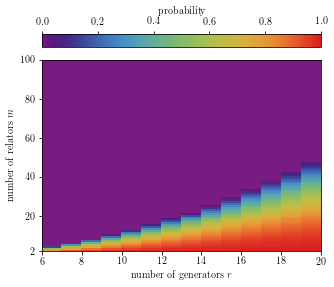

In [27]:
fig, ax = plt.subplots(figsize=(float(5),float(4)))

pcol = plt.pcolormesh(X_rm,Y_rm,Z_rm_lower,cmap=colmap,vmin=0.0, vmax=1.0,rasterized=True)

plt.xlabel("number of generators $r$")
plt.ylabel("number of relators $m$")
plt.xticks([int(i) for i in [6,8,10,12,14,16,18,20]])
plt.yticks([int(i) for i in [2,20,40,60,80,100]])

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("top", size="7%", pad="7%")
cb = plt.colorbar(pcol, cax=cax, orientation="horizontal",label="probability")
cax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")
cb.solids.set_rasterized(True)

plt.savefig("../output/rmLower.pdf",bbox_inches="tight",pad_inches=int(3),dpi=200)

###### upper bound

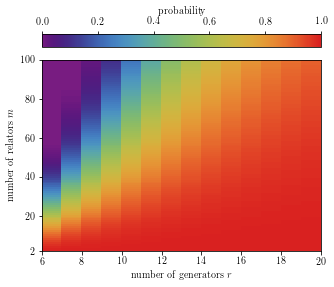

In [28]:
fig, ax = plt.subplots(figsize=(float(5),float(4)))

pcol = plt.pcolormesh(X_rm,Y_rm,Z_rm_upper,cmap=colmap,vmin=0.0, vmax=1.0,rasterized=True)

plt.xlabel("number of generators $r$")
plt.ylabel("number of relators $m$")
plt.xticks([int(i) for i in [6,8,10,12,14,16,18,20]])
plt.yticks([int(i) for i in [2,20,40,60,80,100]])

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("top", size="7%", pad="7%")
cb = plt.colorbar(pcol, cax=cax, orientation="horizontal",label="probability")
cax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")
cb.solids.set_rasterized(True)

plt.savefig("../output/rmUpper.pdf",bbox_inches="tight",pad_inches=int(3),dpi=200)

###### experimental bound

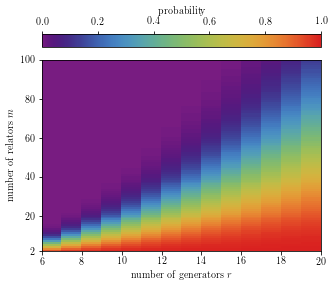

In [29]:
fig, ax = plt.subplots(figsize=(float(5),float(4)))

pcol = plt.pcolormesh(X_rm,Y_rm,Z_rm_exper,cmap=colmap,vmin=0.0, vmax=1.0,rasterized=True)

plt.xlabel("number of generators $r$")
plt.ylabel("number of relators $m$")
plt.xticks([int(i) for i in [6,8,10,12,14,16,18,20]])
plt.yticks([int(i) for i in [2,20,40,60,80,100]])

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("top", size="7%", pad="7%")
cb = plt.colorbar(pcol, cax=cax, orientation="horizontal",label="probability")
cax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")
cb.solids.set_rasterized(True)

plt.savefig("../output/rmExper.pdf",bbox_inches="tight",pad_inches=int(3),dpi=200)

---

### Part 2: length vs. m

#### Generate the data to produce the contour plot

In [30]:
r = 20

X_lm = range(6,30+1) # range of l to use
Y_lm = range(2,40+1) # range of m to use

Z_lm_lower = []
Z_lm_upper = []
Z_lm_exper = []

for length in X_lm:
    for m in Y_lm:
        lower_bound = lowerBound(1/6,r,length,length,m).n(digits=8)
        upper_bound = upperBound(1/6,r,length,m).n(digits=8)
        exper_bound = get_prob(r,m,length,length)
        
        Z_lm_lower = Z_lm_lower + [lower_bound]
        Z_lm_upper = Z_lm_upper + [upper_bound]
        Z_lm_exper = Z_lm_exper + [exper_bound]
        

Z_lm_lower = np.array(Z_lm_lower).reshape((len(X_lm),len(Y_lm))).transpose()
Z_lm_upper = np.array(Z_lm_upper).reshape((len(X_lm),len(Y_lm))).transpose()
Z_lm_exper = np.array(Z_lm_exper).reshape((len(X_lm),len(Y_lm))).transpose()

X_lm = np.array(X_lm)
Y_lm = np.array(Y_lm)

#### Plot the data

##### lower bound

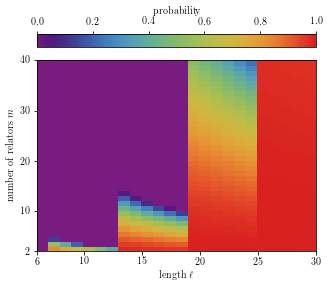

In [31]:
fig, ax = plt.subplots(figsize=(float(5),float(4)))

pcol = plt.pcolormesh(X_lm,Y_lm,Z_lm_lower,cmap=colmap,vmin=0.0, vmax=1.0,rasterized=True)

plt.xlabel("length $\ell$")
plt.ylabel("number of relators $m$")
plt.xticks([int(i) for i in [6,10,15,20,25,30]])
plt.yticks([int(i) for i in [2,10,20,30,40]])

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("top", size="7%", pad="7%")
cb = plt.colorbar(pcol, cax=cax, orientation="horizontal",label="probability")
cax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")
cb.solids.set_rasterized(True)

plt.savefig("../output/lmLower.pdf",bbox_inches="tight",pad_inches=int(3),dpi=200)

##### upper bound

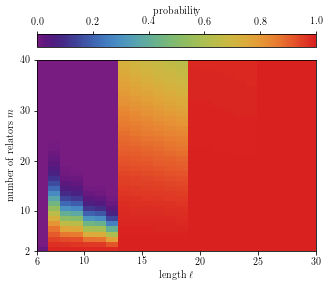

In [32]:
fig, ax = plt.subplots(figsize=(float(5),float(4)))

pcol = plt.pcolormesh(X_lm,Y_lm,Z_lm_upper,cmap=colmap,vmin=0.0, vmax=1.0,rasterized=True)

plt.xlabel("length $\ell$")
plt.ylabel("number of relators $m$")
plt.xticks([int(i) for i in [6,10,15,20,25,30]])
plt.yticks([int(i) for i in [2,10,20,30,40]])

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("top", size="7%", pad="7%")
cb = plt.colorbar(pcol, cax=cax, orientation="horizontal",label="probability")
cax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")
cb.solids.set_rasterized(True)

plt.savefig("../output/lmUpper.pdf",bbox_inches="tight",pad_inches=int(3),dpi=200)

##### experimental bound

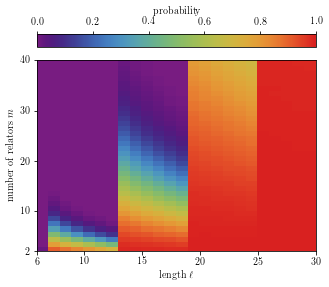

In [33]:
fig, ax = plt.subplots(figsize=(float(5),float(4)))

pcol = plt.pcolormesh(X_lm,Y_lm,Z_lm_exper,cmap=colmap,vmin=0.0, vmax=1.0,rasterized=True)

plt.xlabel("length $\ell$")
plt.ylabel("number of relators $m$")
plt.xticks([int(i) for i in [6,10,15,20,25,30]])
plt.yticks([int(i) for i in [2,10,20,30,40]])

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("top", size="7%", pad="7%")
cb = plt.colorbar(pcol, cax=cax, orientation="horizontal",label="probability")
cax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")
cb.solids.set_rasterized(True)

plt.savefig("../output/lmExper.pdf",bbox_inches="tight",pad_inches=int(3),dpi=200)

---

### Part 3: r vs. length

#### Generate the data to produce the contour plot

In [39]:
m = 10

X_lr = range(2,40+1) # range of l to use
Y_lr = range(6,50+1) # range of r to use

Z_lr_lower = []
Z_lr_upper = []
Z_lr_exper = []

for length in X_lr:
    for r in Y_lr:
        lower_bound = lowerBound(1/6,r,length,length,m).n(digits=8)
        upper_bound = upperBound(1/6,r,length,m).n(digits=8)
        exper_bound = get_prob(r,m,length,length)
        
        Z_lr_lower = Z_lr_lower + [lower_bound]
        Z_lr_upper = Z_lr_upper + [upper_bound]
        Z_lr_exper = Z_lr_exper + [exper_bound]
        
Z_lr_lower = np.array(Z_lr_lower).reshape((len(X_lr),len(Y_lr))).transpose()
Z_lr_upper = np.array(Z_lr_upper).reshape((len(X_lr),len(Y_lr))).transpose()
Z_lr_exper = np.array(Z_lr_exper).reshape((len(X_lr),len(Y_lr))).transpose()

X_lr = np.array(X_lr)
Y_lr = np.array(Y_lr)

#### Plot the data

##### lower bound

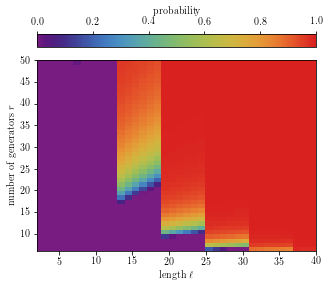

In [40]:
fig, ax = plt.subplots(figsize=(float(5),float(4)))

pcol = plt.pcolormesh(X_lr,Y_lr,Z_lr_lower,cmap=colmap,vmin=0.0, vmax=1.0, rasterized=True)

plt.xlabel("length $\ell$")
plt.ylabel("number of generators $r$")
plt.xticks([int(i) for i in [5,10,15,20,25,30,35,40]])
plt.yticks([int(i) for i in [10,15,20,25,30,35,40,45,50]])

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("top", size="7%", pad="7%")
cb = plt.colorbar(pcol, cax=cax, orientation="horizontal",label="probability")
cax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")
cb.solids.set_rasterized(True)

plt.savefig("../output/lrLower.pdf",bbox_inches="tight",pad_inches=int(3),dpi=200)

##### upper bound

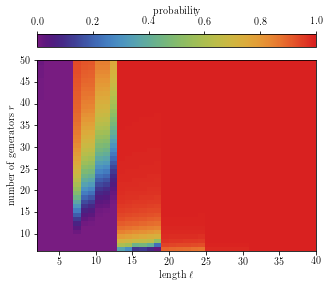

In [41]:
fig, ax = plt.subplots(figsize=(float(5),float(4)))

pcol = plt.pcolormesh(X_lr,Y_lr,Z_lr_upper,cmap=colmap,vmin=0.0, vmax=1.0, rasterized=True)

plt.xlabel("length $\ell$")
plt.ylabel("number of generators $r$")
plt.xticks([int(i) for i in [5,10,15,20,25,30,35,40]])
plt.yticks([int(i) for i in [10,15,20,25,30,35,40,45,50]])

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("top", size="7%", pad="7%")
cb = plt.colorbar(pcol, cax=cax, orientation="horizontal",label="probability")
cax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")
cb.solids.set_rasterized(True)

plt.savefig("../output/lrUpper.pdf",bbox_inches="tight",pad_inches=int(3),dpi=200)

##### experimental bound

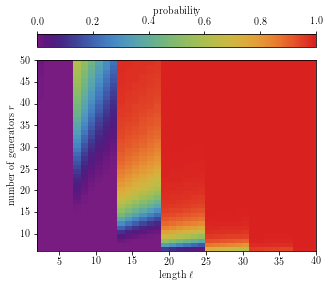

In [42]:
fig, ax = plt.subplots(figsize=(float(5),float(4)))

pcol = plt.pcolormesh(X_lr,Y_lr,Z_lr_exper,cmap=colmap,vmin=0.0, vmax=1.0, rasterized=True)

plt.xlabel("length $\ell$")
plt.ylabel("number of generators $r$")
plt.xticks([int(i) for i in [5,10,15,20,25,30,35,40]])
plt.yticks([int(i) for i in [10,15,20,25,30,35,40,45,50]])

ax_divider = make_axes_locatable(ax)
cax = ax_divider.append_axes("top", size="7%", pad="7%")
cb = plt.colorbar(pcol, cax=cax, orientation="horizontal",label="probability")
cax.xaxis.set_ticks_position("top")
cb.ax.xaxis.set_label_position("top")
cb.solids.set_rasterized(True)

plt.savefig("../output/lrExper.pdf",bbox_inches="tight",pad_inches=int(3),dpi=200)